# Art Style Classification using CNN

### Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, BatchNormalization, GlobalAveragePooling2D, Resizing
from tensorflow.keras.layers import Input, Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet121, VGG19
from tensorflow.keras.losses import sparse_categorical_crossentropy

### Train/Test Split

In [4]:
# Constants used in the CNN model

data_dir = 'processed'

IMG_HEIGHT, IMG_WIDTH = 512, 512
TARGET_HEIGHT, TARGET_WIDTH = 224, 224

BATCH_SIZE = 32
VALIDATION_SPLIT = 0.3


NUM_CLASSES = 13
EPOCHS = 15

In [6]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Split val into val + test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds  = val_ds.skip(val_batches // 2)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

class_names = train_ds.class_names
print(f"Art Styles (Class Names): {class_names}")

Found 42385 files belonging to 13 classes.
Using 29670 files for training.
Found 42385 files belonging to 13 classes.
Using 12715 files for validation.
Train batches: 928
Val batches: 199
Test batches: 199
Art Styles (Class Names): ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Western_Medieval']


## Creating CNN model and training it

In [9]:
model = Sequential([
    Resizing(TARGET_HEIGHT, TARGET_WIDTH, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(
    optimizer='adam',
    loss=sparse_categorical_crossentropy,
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,402,765 (169.38 MB)

 Trainable params: 44,402,765 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 277s 298ms/step - accuracy: 0.2844 - loss: 2.1156 - val_accuracy: 0.4035 - val_loss: 1.8208
Epoch 2/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 283s 305ms/step - accuracy: 0.3943 - loss: 1.8042 - val_accuracy: 0.4963 - val_loss: 1.5257
Epoch 3/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 305s 329ms/step - accuracy: 0.4882 - loss: 1.5319 - val_accuracy: 0.5678 - val_loss: 1.3321
Epoch 4/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 301s 324ms/step - accuracy: 0.5867 - loss: 1.2236 - val_accuracy: 0.6542 - val_loss: 1.1439
Epoch 5/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 307s 331ms/step - accuracy: 0.7044 - loss: 0.8876 - val_accuracy: 0.7063 - val_loss: 1.0464
Epoch 6/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 311s 335ms/step - accuracy: 0.7883 - loss: 0.6480 - val_accuracy: 0.7361 - val_loss: 1.0525
Epoch 7/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 309s 333ms/step - accuracy: 0.8445 - loss: 0.4841 - val_accuracy: 0.7739 - val_loss: 0.9862
Epoch 8/15
928/928 ━━━━━━━━━━━━━━━━━━━━ 304s 328ms/step - accuracy: 0.8786 -

## Evaluating Model on Test Set

In [15]:
loss, accuracy = model.evaluate(test_ds, verbose=0)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Test Loss: 1.0714694261550903
Test Accuracy: 0.8258479833602905


In [19]:
import matplotlib.pyplot as plt

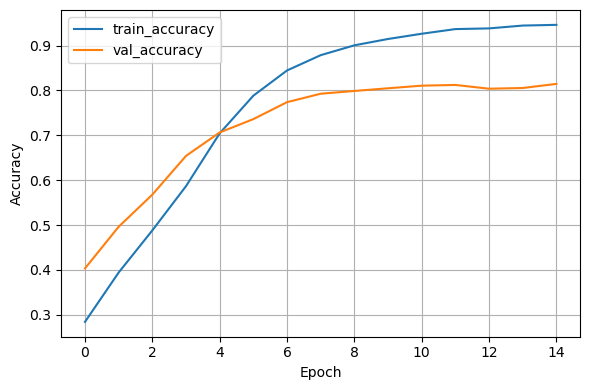

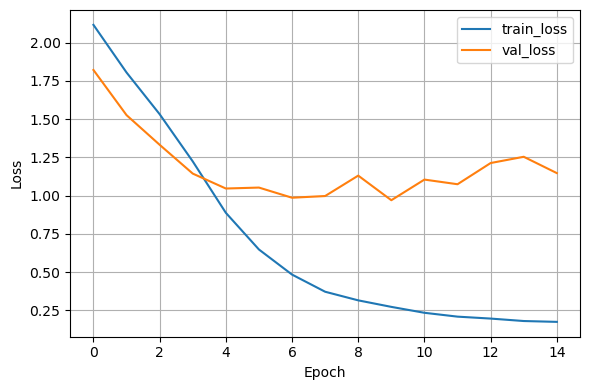

In [21]:
def plot_history(history, metric="accuracy"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history[metric], label=f"train_{metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history, metric="accuracy")
plot_history(history, metric="loss")

## Saving Model

In [24]:
import os

SAVED_MODEL_DIR = './models/art_style_cnn_new.keras'

model.save(SAVED_MODEL_DIR)

print(f"Model saved successfully to directory: {os.path.abspath(SAVED_MODEL_DIR)}")

Model saved successfully to directory: /Users/superman/Desktop/UofT/AI & Deep Learning/RSM8421_Project/models/art_style_cnn_new.keras
